# A Journey Backwards through Time with LSTMs

Neural networks are known as 'universal function approximators' [(Hornik et al., 1989)](https://www.sciencedirect.com/science/article/abs/pii/0893608089900208). If they are indeed universal, it is a fair question to ask why we see so many architectures present in modern deep learning. The reason for this is the structure of problems we wish to consider are varied and there are many inductive biases that can help neural networks to achieve amazing performance when encoded in the network architecture. One clear example of this is convolutional neural networks which encode translation invariance. In this post, we will consider recurrent neural networks, specifically a recurrent neural network imbued with memory. Recurrent neural networks are used to process sequential data. They act to apply the same operations on an evolving state accounting for new data as it arrives. We will consider a particularly popular form of RNN known as a long short-term memory network. LSTMs have a state which is updated at each step alongside a hidden representation of the data so far which is used to make predictions. We will see that this separation of memory and representation will make the RNN easier to train and therefore much more powerful in practice.

As with all neural networks, RNNs are trained using backpropagation. In the case of RNNs, the repeated set of operations requires training to have a specific structure. The training of RNNs is sometimes referred to as backpropagation through time as the gradients have to be passed from predictions backwards through time to reflect the forward temporal processing of the data. We note that not all sequences are time series, however they are processed in sequence and therefore there the data can be considered to be processed in wall-time order. Without loss of generality and for clarity of exposition, we will consider the data to be time series during this post.

In this article, we will describe and implement and train an LSTM from scratch. We focus on the training and the derivation of backpropagation through time. Whilst we introduce RNNs and LSTMs, we refer the inquisitive reader to Christopher Olah's [renowned blog post](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) on LSTMs. His short essay on the design and intuition of LSTMs is the best introduction to the models and we do not believe we could improve upon it here (in fact we have borrowed a couple of diagrams). In this article, we go further into the technical details and derive the gradients for these models from scratch. This is a great exercise in understanding how to train neural networks and understanding the computation graphs. If you can work out the gradients for an LSTM you can probably work out the gradients for any typical neural network!

We implement the LSTM and its training in Julia and tackle some hand-crafted tasks to demonstrate some of the abilities of LSTMs on a scale suitable for the compute power of a laptop. A link to the code is available at the end of the article.

> ### A quick note on Julia
> Julia has great [introductory tutorials](https://julialang.org/learning/) and is readable to even beginner programmers. It is important to our applications here to understand the following Julia syntax. The `*` operator when applied to vectors and/or matrices performs matrix multiplication. In fact, matrix operations are performed by default. For vectorised processing the following syntax is used `a .* b`. This syntax is extended to functions. For example `log(A)` takes the matrix logarithm of the matrix `A` whereas `log.(A)` performs the elementwise logarithm. Finally, it is important to know that Julia uses 1-based indexing and that functions which cause side effects are prepended with `!` (e.g. `plot(...)` will plot on a new set of axes whereas `plot!(...)` will act to mutate the currently available axes object to overlay a new plot).

## From RNN to LSTM

In order to persist ideas while processing a sequence, recurrent neural networks pass the output from each application of the network as an input to the network at the next time period. RNNs are therefore applying the same network again and again with only the inputs to the network changing.

![img](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png)

<center><span style="color:gray"><i>An RNN unrolled to demonstrate the repeated actions through time. Graphic from Chris Olah's great <a href="http://colah.github.io/posts/2015-08-Understanding-LSTMs/">blog post</a>.</i></span></center>

The passing of the so-called 'hidden state' from one application to the next resembles the application of a very deep network which also accepts external inputs to each layer. Training such a network would involve propagating gradients backwards through the depth of the network.

With an RNN the application of the network through a sequence leads to propagating gradients backwards through time. Moreover, because the same network is applied at each stage the gradients used to update the weights of the network need to be summed from all applications. If this were the case for the analogous deep network discussed above, the weights in each layer would be constrained to be the same. This constraint is known as weight tying.

The tying of the weights to be the same makes the calculation of gradients more difficult as there are many components of the gradient to calculate which can be easily found through the application of the chain rule. We will see this in detail later on.

It is well known that training very deep networks can be challenging. When training we apply the chain rule of differentiation to the network to find the gradient of the loss with respect to the weights of the neural network. For deep networks or RNNs applied to long time series, this leads to a product of many gradients. We can use this simple understanding of training to see where issues may arise.

The gradients of activation functions such as the sigmoid and tanh functions are in the unit interval and therefore repeated application leads to diminishing gradients and therefore only very slow training for weights earlier in the network. In the case of an RNN this translates to not being able to learn long-term dependencies (as the training signal does not effectively propagate back far enough).

Furthermore, the gradient of a typical layer of a neural network with respect to its inputs in the absence of an activation function is given by the transpose of its weights matrix scaled by the derivative of the activation function. When we tie the weights of a network the gradient with respect to deep layers therefore involves a term in the weight matrix to high powers. Where the eigenvalues of the weights matrix are above 1 this leads to vanishing gradients as the repeated matrix multiplication leads to small values. Where the eigenvalues are above 1 this leads to exploding gradients, which can lead to instability as they lead to large parameter updates. Given that the initialisation and evolution (under stochastic gradient descent) of the weights matrices is random we cannot avoid training issues from vanishing or exploding gradients.

General solutions to the training difficulties describe above include the use of alternative activation functions such as the so-called rectified linear unit (ReLU), the use of residual links in networks, clipping or synthesising gradients and simply using more computational power. However, in 1997 S. Hochreiter and J. Schmidhuber introduced a solution specific to recurrent neural networks known as long short-term memory [(Hochreiter and Schmidhuber, 1997)](https://ieeexplore.ieee.org/abstract/document/6795963). These models separate the representation of the data so far from a memory source to allow a clean path through which gradients can propagate.

### LSTMs: The Forward Pass

To process a sequence of inputs, at each time period, an LSTM takes as input the next data point, $x_t$, as well as the state and output from the previous application of the LSTM, $s_{t-1}$ and $h_{t-1}$ respectively. We copy Chris Olah's diagram below which depicts the operations of an LSTM before we continue to explain the inner workings of the network.

![LSTM Diagram](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png)
<center><span style="color:gray"><i>LSTM unrolled for three time steps. Taken from Chris Olah's great <a href="http://colah.github.io/posts/2015-08-Understanding-LSTMs/">blog post</a>.</i></span></center>

The output of the previous layer and the new input are concatenated together to produce a vector we represent as $h^+_t$ to simplify the notation and to make the equations better align with the code. Note that, at the first step, the initial state and hidden inputs, $s_0$ and $h_0$ are provided; these are learnable parameters.

$$h^+_t = \begin{bmatrix}1 \\ x_t \\ h_{t-1}\end{bmatrix}$$

The LSTM then calculates which elements of memory to 'forget' to make space for new information. This is done by first calculating the values of a 'forget' get which is later used to scale the state. The 'gates' are all passed through a sigmoid activation function (applied elementwise to vector inputs) which yields values in the unit interval. This is useful to ensure that information is always represented on the same scale and ensures that 'forgetting' and 'remembering' can be implemented in the space of elementwise addition.

$$f = \sigma(W_fh^+_{t})$$

With space made from forgetting, the LSTM state is updated with new information. The new information is generated from the inputs provided and we denote it as the vector $a_t$.

$$a_t = \tanh(W_ah^+_{t})$$

Again to control the flow of information, the update to the state is gated using what we term a 'remember' gate.

$$r_t = \sigma(W_rh^+_{t})$$

We now have all the elements we need to write the cell update equation.

$$s_{t} = f_t \otimes s_{t-1} + r_t \otimes a_t$$

With the state updated the LSTM is then able to generate its outputs. This is again achieved by first forming a gate before then generating the final outputs. This gate is known as the 'output gate'.

$$o_t = \sigma(W_o h^+_t)$$

$$h_t = o_t \otimes \tanh(s_t)$$

We start the implementation of our LSTM with the forward pass. First we must import some packages which will be useful throughout this article.

>Note that in the code we use `Wᵥ` to denote the parameters of the forget gate as the subscript `v` is easily available with a Julia shortcut unlike subscript `f`.

In [1]:
using Plots
using LaTeXStrings
using Random
using ProgressMeter
using Statistics

Before we implement anything more technical we take a moment to quickly implement a useful utility function which returns a variable of the same shape as the provided value but with all zero entries.

In [2]:
function zeros_like(mtx)
    #= Makes a zeros matrix with the same dimensions as the input matrix (mtx) =#
    return zeros(size(mtx))
end;    

As we can tell from the mathematical description of the forward pass, we need both the sigmoid function (denoted by $\sigma$) and the $\tanh$ function as activation functions. We will also need their derivatives in order to calculate the gradients required for training the network. We calculated the gradient of the sigmoid function in an [earlier article](https://www.solvesmart.co.uk/article/an-introduction-to-neural-networks-multi-layer-perceptron). We can similarly calculate the derivative of the $\tanh$ function using [the quotient rule](https://en.wikipedia.org/wiki/Quotient_rule).

$$\tanh(x) = \frac{1-e^{-2x}}{1+e^{-2x}}$$

$$\frac{\partial \tanh(x)}{\partial x} = \frac{2e^{-2x}((1+e^{-2x}) + (1-e^{-2x}))}{\left(1+e^{-2x}\right)^2}= \frac{4e^{-2x}}{\left(1+e^{-2x}\right)^2}$$

We denote the derivative functions as $\nabla f(x)$.

In [4]:
function σ(x)
    return 1/(1+exp(-x))
end
function ∇σ(x)
    σₓ = σ(x)
    return σₓ * (1 - σₓ)
end
function tanh(x)
    t = exp(-2*x)
    return (1-t)/(1+t)
end
function ∇tanh(x)
    t = exp(-2*x)
    return (4*t)/(1+t)^2
end;

To better understand these activation functions and to demonstrate the vanishing gradients problem, we plot the function values themselves along with their derivatives below.

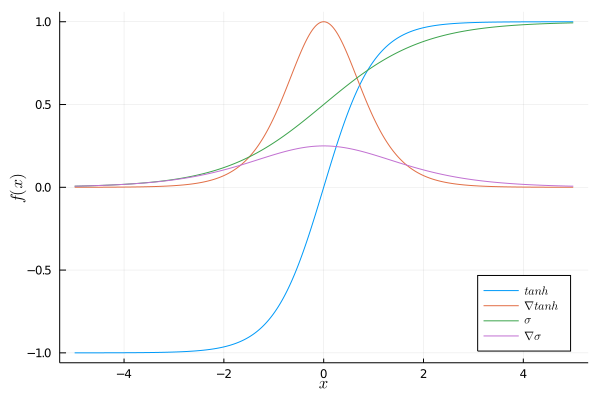

In [7]:
x = -5.0 .+ cumsum(0.01 .* ones(1000))
y₁ = tanh.(x)
y₂ = ∇tanh.(x)
y₃ = σ.(x)
y₄ = ∇σ.(x)
plot(x, y₁, label=L"tanh", background_color="transparent")
plot!(x, y₂, label=L"\nabla tanh", foreground_color="black")
plot!(x, y₃, label=L"\sigma", background_color_legend="white")
plot!(x, y₄, label=L"\nabla \sigma", legend=:bottomright)
xaxis!(L"x")
yaxis!(L"f(x)")

We see that the sigmoid function has a range in the unit interval and a first derivative in the interval $[0, 0.25]$. The hyperbolic tangent function however has image $[-1, 1]$ and first derivative in the unit interval. This helps us to see both the saturating of these activation functions at extreme values (leading to very small gradients and thus little to no learning) as well as the vanishing gradient issue whereby the chain rule leading to the multiplication of gradients smaller than 1 and thus very small gradients for very deep networks.

With the nature of these functions in mind, we now implement the forward pass of the LSTM in Julia and discuss a few key design ideas. We start with the core repeated operations of the LSTM grouped together in what is sometimes referred to as an LSTM cell. This handles the mapping of a new external input, the output from the last LSTM application and the LSTM state to a new LSTM output and updated state.

In [5]:
function LSTM_Cell(x, h, s, Wᵥ, Wᵣ, Wₐ, Wₒ)
    #= Implementation of an LSTM for a single period
    
    Inputs
    x - The exogenous input for the current period
    h - The endognenous input (from the previous period)
    s - The current LSTM state
    Wᵥ - The weights matrix for the forget gate
    Wᵣ - The weights matrix for the remember gate
    Wₐ - The attention weights
    Wₒ - The weights matrix for the output gate
    =#
    # Concatenate the inputs
    h₊ = [1; x; h]
    
    # Forget Gate
    f = σ.(Wᵥ * h₊)
    
    # Remember Gate
    r = σ.(Wᵣ * h₊)
    
    # Output gate
    o = σ.(Wₒ * h₊)

    # Attention Values
    a = tanh.(Wₐ * h₊)
    
    # Update the state
    s_new = f .* s + r .* a
    
    # Produce new output
    h_new = o .* tanh.(s_new)
    
    gates = (f=f, r=r, a=a, o=o)
    cache = (gates=gates, h=h_new, h⁺₋₁=h₊, h₋₁=h, s=s_new, s₋₁=s)
    return h_new, s_new, cache
end;

Note that the function, as we have written it, caches the values of the LSTM and some intermediate calculated values (the values of the gates). This is done to aid in training the network when we will call upon the cached values to enable us to evaluate the gradients of the network quickly without having to calculate them over again.

The LSTM cell returns an output vector $(h_t)$ and the updated LSTM state $(s_t)$. In order to attain a prediction, we add an output layer which maps the LSTM output to a prediction. This can be applied whenever we wish to attain a prediction. In the cases we will consider, we will have a simple single-layer perceptron with no activation function so that the output is unlimited. We map to a scalar output as this is all that will be required for our simple problems. This final layer therefore becomes an inner product between a weights vector and the output of the LSTM (with an additional 1 prepended to act as a bias).

In [6]:
function output_layer(h̃, Wᵩ)
    #= Single layer perceptron for generating final LSTM output =#
    return Wᵩ * [1; h̃]
end;

We can put the LSTM cell together with the output layer into a full sequence processing function termed `forward_propagation`. This essentially applies the operations of the LSTM at each time step in a for loop, caching values as it goes. The output of the network is only taken at the final timestep. This is unusual for an RNN as typically an output is calculated at each time step. We make this restiction to simplify the problems we consider and the derivation and calculation of the gradients. This is because we focus on deriving the weight updates for an LSTM. We will see that extentsion to the case of generating an output at each time step is fairly easy but adds a lot of terms which can make life difficult when it comes to implementation.

The forward propagation function returns the LSTM cell outputs for each time step as well as the cached values from each time step and a final prediction. We now have all we need to run the network as well as all of the outputs we require to set up training.

In [7]:
function forward_propagation(X, h₀, s₀, Wᵥ, Wᵣ, Wₐ, Wₒ, Wᵩ)
    # Find the length of the sequence
    T = size(X, 2)
    # Initialise tables to store the LSTM outputs and the states
    # These hold states and outputs from 1 to T (i.e. exclude h₀ and s₀)
    H = zeros(length(h₀), T)
    S = zeros(length(s₀), T)
    
    # Initialise a list to add the cache tuples to
    # These will be useful when training the model
    cache = []
    
    # Run forwards through the sequence collecting the outputs accordingly
    for t = 1:T
        if t == 1
            H[:, t], S[:, t], c = LSTM_Cell(X[:, t], h₀, s₀, Wᵥ, Wᵣ, Wₐ, Wₒ)
        else
            H[:, t], S[:, t], c = LSTM_Cell(X[:, t], H[:, t-1], S[:, t-1], Wᵥ, Wᵣ, Wₐ, Wₒ)
        end
        push!(cache, c)
    end
    
    # Attain the ultimate classification of the sentence
    ŷ = output_layer(H[:, T], Wᵩ)
    
    return H, S, cache, ŷ
end;

## Deriving Backpropagation Through Time

The operations of back propagation act to propagate the training signal (i.e. the gradient of the loss function) to the parameters to be updated. This propagation essentially reverses the direction of the forward pass taking a product of the gradients along a path from the loss to the parameters to be updated. In the case of an RNN this requires propagating the gradients 'backwards through time'.

To see this most clearly, let us write the forward operation of an LSTM as a computation graph. We may then see the path from the weights to the output to be reversed in training. The calculation of weight updates is essentially an application of the chain rule; however, looking at it through the lens of the computation graph will enable us to see how to calculate these updates in an intuitive way.

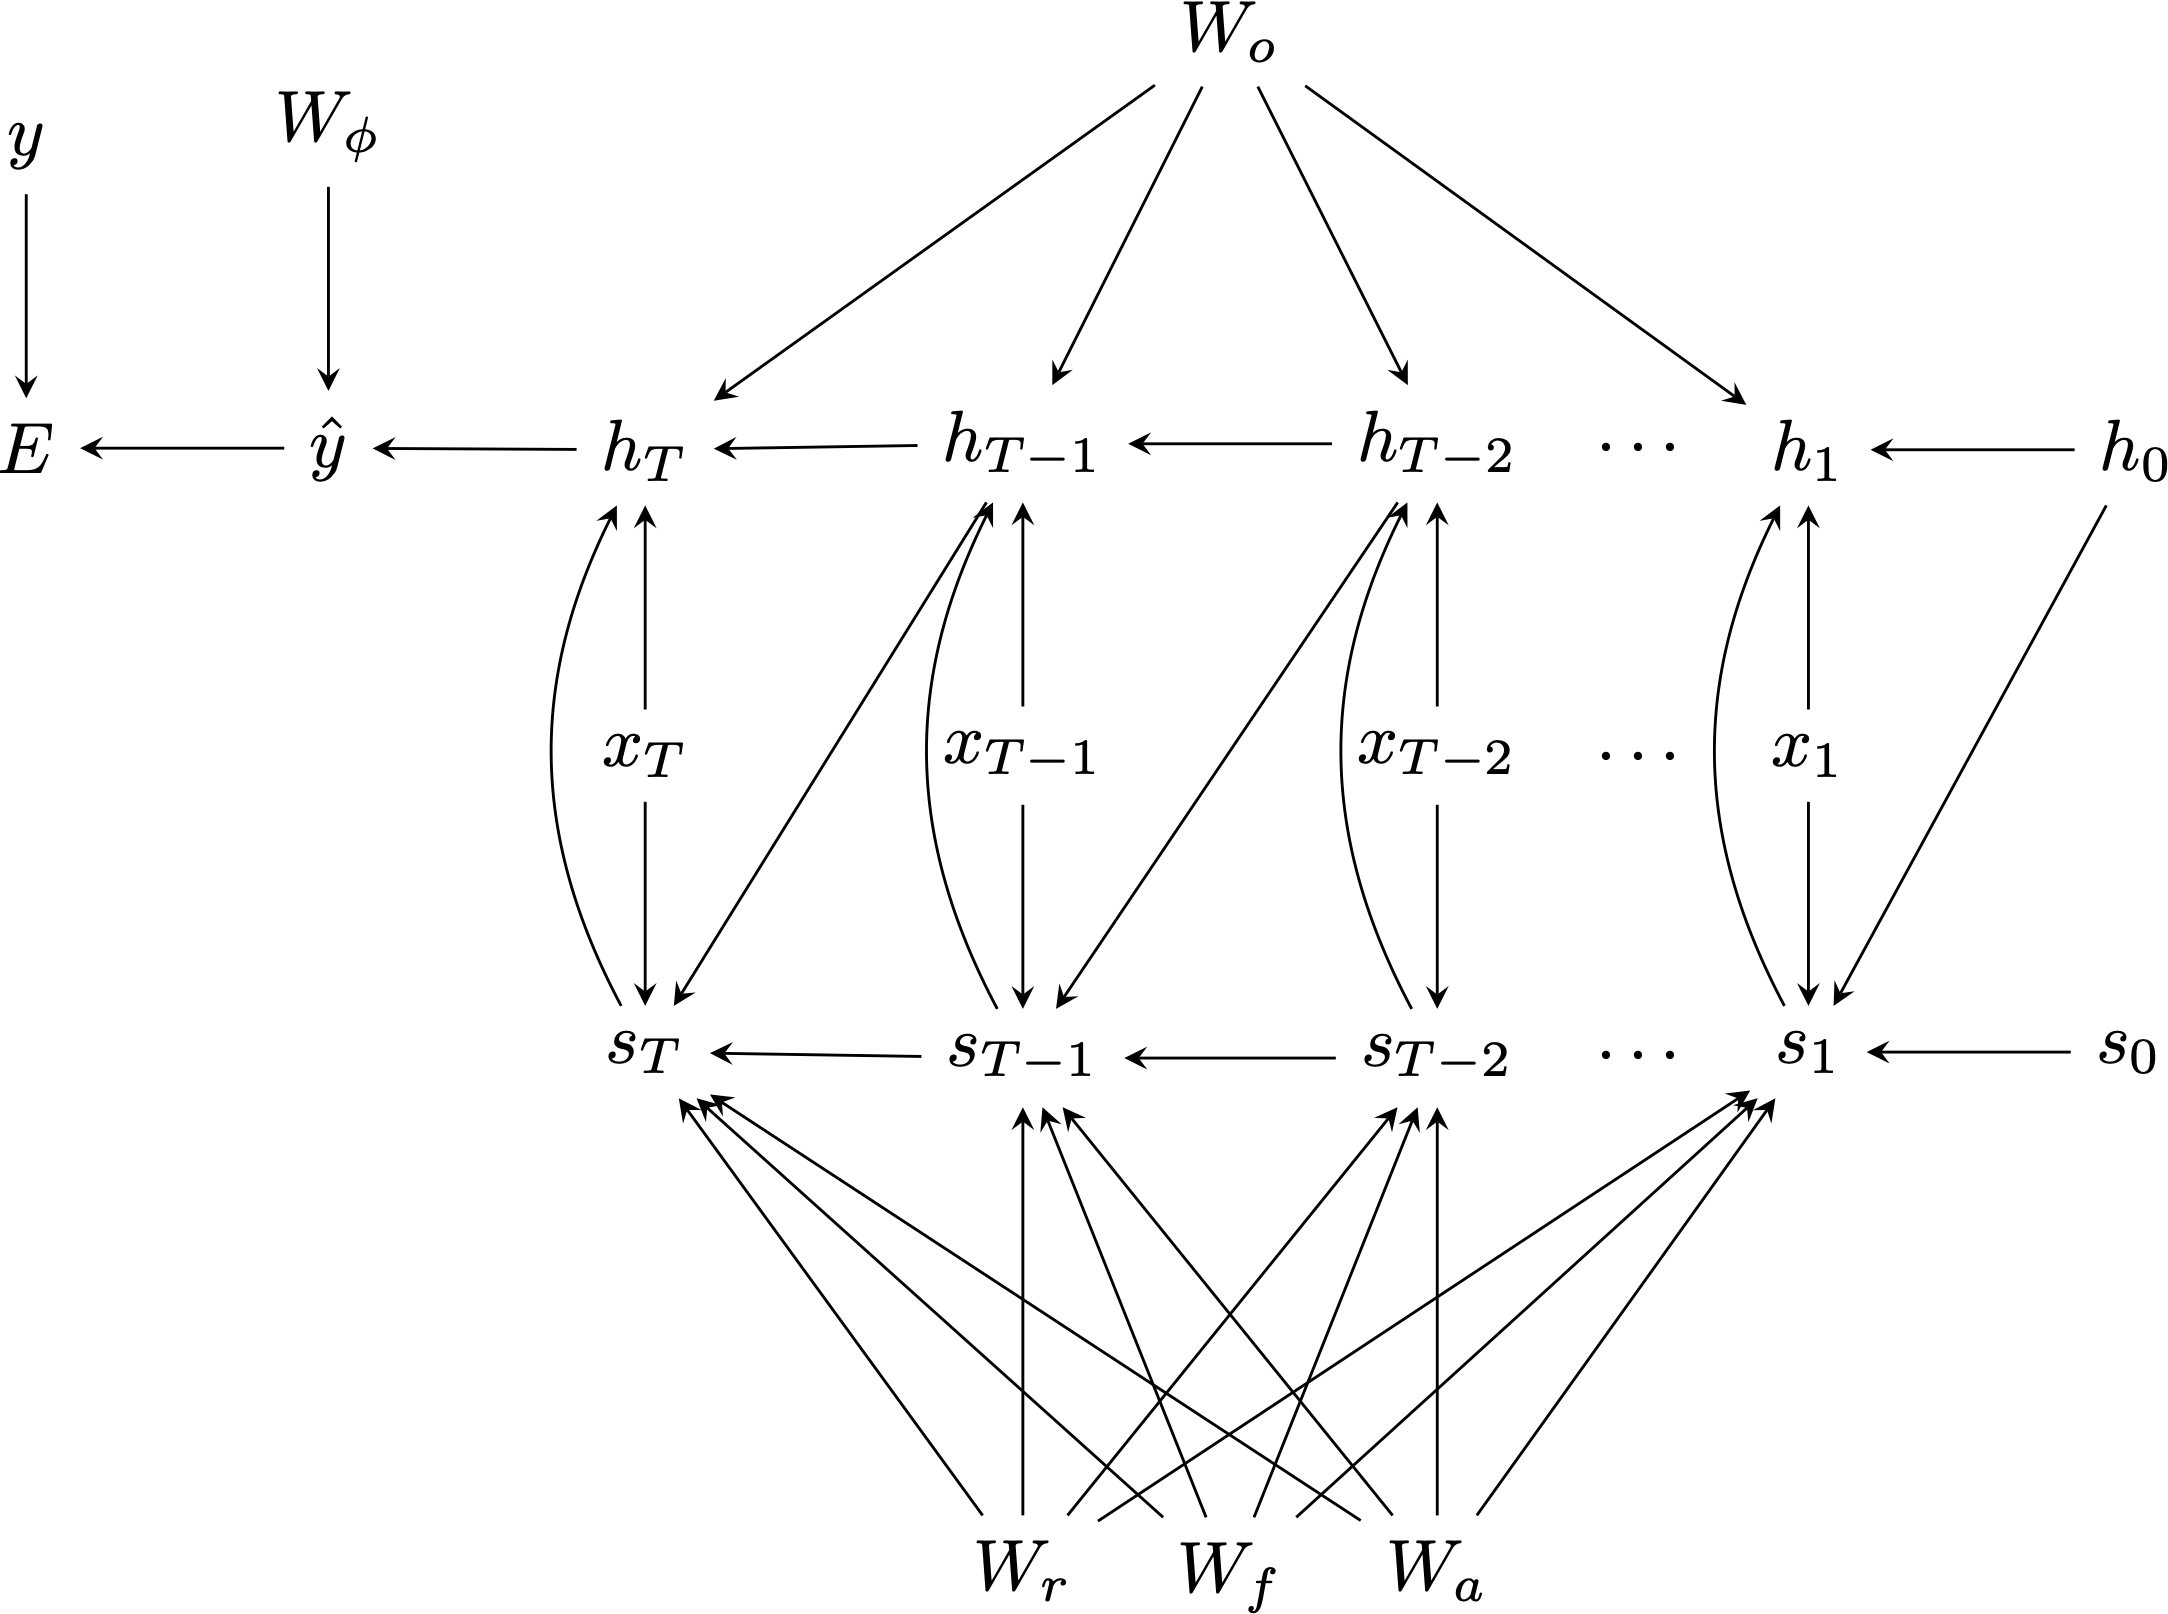

We may see in the diagram that, during the forward pass the cell weights, $(W_f, W_r, W_a, W_o)$ are involved at every time step. As such there are many routes from the loss $(\mathcal{L})$ to the weights. In order to attain the true gradients, we need to calculate the gradient along each path from the loss to the weight in question and then sum all of the resulting gradients. The gradient along the path can be calculated via the chain rule by taking the product along the path.

> Note that throughout this section where we consider the gradient of one vector or matrix with respect to another, we assume to arrive at a resulting vector which has the same shape as the vector or matrix we are taking the gradient with respect to. Typically, one may expect that the gradient of a vector with respect to another vector should result in a matrix as each pair of elements is considered separately. When deriving backpropagation it saves time and effort to sum the derivative terms over the elements of the vector or matrix we are taking the gradient of. This is possible as we are ultimately taking the gradient of a scalar, the loss, and wish to sum over all paths from a parameter to the loss during backpropagation. In this way, we are saving time by taking this sum as we go and we will therefore ultimately arrive at a gradient object which has the same shape as the parameter matrix (or vector) we wish to update.

Let us begin with a single weights matrix as a clarifying example. Considering the weights matrix $W_o$ we attain the following gradient

$$
\begin{align}
\frac{\partial \mathcal{L}}{\partial W_o} &= 
\frac{\partial\mathcal{L}}{\partial\hat{y}}\frac{\partial\hat{y}}{\partial h_T}\frac{\partial h_T}{\partial W_o}
\\&+
\frac{\partial\mathcal{L}}{\partial\hat{y}}\frac{\partial\hat{y}}{\partial h_T}\frac{\partial h_T}{\partial h_{T-1}}\frac{\partial h_{T-1}}{\partial W_o}
\\&+
\frac{\partial\mathcal{L}}{\partial\hat{y}}\frac{\partial\hat{y}}{\partial h_T}\frac{\partial h_T}{\partial s_T}\frac{\partial s_T}{\partial h_{T-1}}\frac{\partial h_{T-1}}{\partial W_o}
\\&+
\frac{\partial\mathcal{L}}{\partial\hat{y}}\frac{\partial\hat{y}}{\partial h_T}\frac{\partial h_T}{\partial s_T}\frac{\partial s_T}{\partial s_{T-1}}\frac{\partial s_{T-1}}{\partial h_{T-2}}\frac{\partial h_{T-2}}{\partial W_o}
\\&+
\frac{\partial\mathcal{L}}{\partial\hat{y}}\frac{\partial\hat{y}}{\partial h_T}\frac{\partial h_T}{\partial s_T}\frac{\partial s_T}{\partial h_{T-1}}\frac{\partial h_{T-1}}{\partial W_o}
\\&+\cdots\\
&= 
\frac{\partial\mathcal{L}}{\partial\hat{y}}\frac{\partial\hat{y}}{\partial h_T}
\sum_{t=1}^T\frac{dh_T}{dh_t}\frac{\partial h_t}{\partial W_o}
\end{align}
$$

We may see that the series of calculations required ultimately has a repeating pattern where at each time step the gradients up until the current time step with respect to the LSTM state and output are moved a step further backwards through time. Going back to our diagram; this is done by backtracking along all paths from the current ouput and state of the LSTM to the outputs at the previous time steps. This explains the presence of the terms in $\frac{\partial h_t}{\partial h_{t-1}}$, $\frac{\partial h_t}{\partial s_t}\frac{\partial s_t}{\partial s_{t-1}}$ and $\frac{\partial h_t}{\partial s_t}\frac{\partial s_t}{\partial h_{t-1}}$. We may see that without keeping track of the gradients as we go there are exponentially more and more paths from each LSTM output to previous outputs as information is propagated from output to output and from state to state. When implementing the calculation of these gradients, we therefore keep track of $\frac{dh_T}{dh_t}$ and $\frac{dh_T}{ds_t}$ at each time step (we derive these terms in more detail below when considering the initial LSTM intputs). We are then free to calculate the derivative of the LSTM states and outputs with repect to the LSTM parameters as we go (again maintaining sums where necessary). Note that in the case of $W_o$, which only enters the operations of the LSTM when calculating the new output $h_{t+1}$, we care about tracking the gradients with respect to the LSTM cell outputs. Contrastingly, for the other parameters of the LSTM cell, which are used to calculate the new cell state $(s_{t+1})$, we care about the gradients with respect to the LSTM cell states. However, due to the operations of the LSTM cell it is important to track the gradients with respect to both the cell state and the cell output in both cases to be sure to follow all paths from the loss to the parameters to be trained.

We can see that the resulting calculation will require long sums formed from many product terms. This exposes an underlying algorithm which we have implicitly used to compute the gradient from a computation graph. At each node on the path from the loss to the parameter we take the product of the incoming gradients with the gradient on the most recent segment of the path and then sum over all incoming paths.

Having derived the gradient for $W_o$ above, we may see that the result is very similar for the other weights of the LSTM, $(W_a, W_r\text{ and } W_f)$. The gradient with respect to the weights of the final output layer $(W_\phi)$ is much simpler and the gradients with respect to the initial LSTM cell state and input $(s_0, h_0)$ can be easily derived from the gradients calculated up to $h_1$ and $s_1$. All of these calculations have many similar components. Let us calculate the components we need to calculate the over all gradients below, as they are repeated often and once we have the components we can easily put them together to form the final calculations we need.

We start by defining the loss function. We will consider regression problems where the task is to get the scalar output as close as possible to the target value. Therefore, we use a quadratic loss function. However, the process for deriving the parameter updates is the same with other losses or objectives, simply replace the gradient of this quadratic loss with the gradient of your chosen loss function.

$$\mathcal{L}(y, \hat{y}) = \tfrac{1}{2} (y - \hat{y})^2$$

It is then simple to calculate the derivative we need.

$$\frac{\partial\mathcal{L}}{\partial \hat{y}} = \hat{y} - y$$

Before we move on, let's implement the loss and its derivative ready for use later on.

In [8]:
function loss(y, ŷ)
    return sum(0.5 .* (y - ŷ).^2)
end

function ∇loss(y, ŷ)
    return (ŷ - y)
end;

Once we have the derivative of the loss we can calculate the derivative with respect to the weights of the final output layer $(W_\phi)$. In this case, as the output layer has no activation function the derivative is quite simple.

$$\hat{y} = W_\phi \begin{bmatrix}1 \\ h_T\end{bmatrix}$$
$$\frac{\partial\hat{y}}{\partial W_\phi} = \mathbf{1} \begin{bmatrix}1 \\ h_T\end{bmatrix}^\top$$

We can combine this with the derivative of the loss function with respect to $\hat{y}$, to attain the full derivative for $w_\phi$ to be used to update it.

$$\frac{\partial \mathcal{L}}{\partial W_\phi} = \frac{\partial \mathcal{L}}{\partial \hat{y}}\frac{\partial\hat{y}}{\partial W_\phi} = (\hat{y}-y) \times \mathbf{1}\begin{bmatrix}1\\h_T\end{bmatrix}^\top$$

We implement this below making, use of the fact that Julia can handle the broadcasting for us.

In [9]:
function ∂L∂Wᵩ(y, ŷ, h̃)
    ΔWᵩ = ∇loss(y, ŷ) * [1; h̃]'
    return ΔWᵩ
end;

The next step backwards in time is to calculate the derivative of the prediction, $\hat{y}$, with respect to $h_T$. As above, to aid understanding we will first write the forward equation and then the derviative.

$$\hat{y} = W_\phi\begin{bmatrix}1\\h_T\end{bmatrix}$$
$$\frac{\partial \hat{y}}{\partial h_T} = W_\phi[2:]\mathbf{1}$$
where we are using 1-based indexing to be consisistent with Julia when we remove the first column of the weights matrix $W_\phi$ (as this does not interact with $h_T$). In the code, we refer to $h_T$ as $\tilde{h}$ as we are limited in the subscripts available to use in unicode easily implementable in Julia. We implement this derivative below.

In [10]:
function calculate_h̃_error(y, ŷ, Wᵩ, h̃)
    #= Translate the prediction error in terms of LSTM output =#
    ∇h̃ = Wᵩ' * ∇loss(y, ŷ)
    return  ∇h̃[2:end]
end;

To continue backwards through time, we require four more derivatives. The derivative of the output of the LSTM $h_t$ with respect to the most recent state of the LSTM, $s_t$, the derivative of the output of the LSTM $h_t$ with respect to the previous output of the LSTM, $h_{t-1}$, and the derivatives of the cell state $s_t$ with respect to the previous output of the LSTM, $h_{t-1}$, and the previous cell state $s_{t-1}$. We may see this from the computation graph (ignoring the weight matrices for now) by seeing that the direct parents of the cell output, $h_t$, are the cell state, $s_t$, and the previous output, $h_{t-1}$. In order to consider all paths to the previous cell output, $h_{t-1}$, we note that the cell state, $s_t$, is a child of the previous cell output, $h_{t-1}$.

Let's begin by deriving the simplest of these derivatives, that of the state of the LSTM cell with respect to the previous cell state. For this, and all other derivatives we shall derive, we assume that we have access to the gate values (this highlights the importance of caching values during the forward pass!).

First recall that
$$s_{t} = f_t \otimes s_{t-1} + r_t \otimes a_t$$

Therefore, the derivative we require is simply
$$\frac{\partial s_t}{\partial s_{t-1}} = f_t$$

Now let us consider the next simplest of the derivatives we seek, that of the current cell output with respect to the current cell state. Again, we first state the forward equation to make understanding the derivative easy.

$$h_t = o_t \otimes \tanh(s_t)$$
$$\frac{\partial h_t}{\partial s_t} = o_t \otimes \tanh'(s_t)$$

Here we have used the deirvative of the $\tanh$ function applied elementwise (as derived in the section on activation functions).

We may now move on to the slightly more complex derivative of the cell output with respect to the previous cell output. Note that we are not yet interested in the derivative of the cell state with respect to the previous cell input as we will consider that derivative separately.

$$\frac{\partial h_t}{\partial h_{t-1}} = \frac{\partial o_t}{\partial h_{t-1}} \otimes \tanh(s_t)$$
Recall that
$$o_t = \sigma (W_o h^+_{t-1})$$
and therefore since
$$o_t = \sigma(W_oh_{t-1}^+)$$
we have
$$\frac{\partial o_t}{\partial h_{t-1}} = (W_o^\top\sigma'(W_oh_{t-1}^+))[-\text{len}(h):]$$
and thus
$$\frac{\partial h_t}{\partial h_{t-1}} = (W_o^\top\sigma'(W_oh_{t-1}^+))\otimes \tanh(s_t))[-\text{len}(h):]$$

Finally, we turn our attention to the derivative of the cell state with respect to the previous LSTM output. Recall that
$$s_t = f_t \otimes s_{t-1} + r_t \otimes a_t$$
then similarly to the derivative of $o_t$ above we have
$$\frac{\partial f_t}{\partial h_{t-1}} = (W_f^\top\sigma'(W_fh_{t-1}^+))[-\text{len}(h_{t-1}):]$$
$$\frac{\partial r_t}{\partial h_{t-1}} = (W_r^\top\sigma'(W_rh_{t-1}^+))[-\text{len}(h_{t-1}):]$$
and with a slight adjustment
$$\frac{\partial a_t}{\partial h_{t-1}} = (W_a^\top\tanh'(W_ah_{t-1}^+))[-\text{len}(h_{t-1}):]$$
Putting this all together we arrive at the following
$$\frac{\partial s_t}{\partial h_{t-1}} = s_t \otimes (W_f^\top\sigma'(W_fh_{t-1}^+) + a_t \otimes W_r^\top\sigma'(W_rh_{t-1}^+ + r_t \otimes W_a^\top\tanh'(W_ah_{t-1}^+))[-\text{len}(h_{t-1}):]$$

We therefore now have all of the partial derivatives we need to form the products and sums necessary to propagate gradients backwards through time.

In order to find the gradients for the initial LSTM state parameters, $h_0$ and $s_0$ we can simply keep propgating gradients back to the start. In some cases, these parameters are not updated and simply left at their initialised zero values. We state the calculation of gradients for these parameters below by way of an iterative process which terminates at $t=0$. This shows how to calculate the $\frac{dh_T}{dh_t}$ and $\frac{dh_T}{ds_t}$ terms we refer to above. This recursion demonstrates the sum-product algorithm applied to the full length of the unrolled LSTM.


$$
\begin{bmatrix}
\frac{dh_T}{ds_t}\\
\frac{dh_T}{dh_t}
\end{bmatrix}
=
\begin{bmatrix}
\left(
\frac{dh_T}{dh_{t+1}}\frac{\partial h_{t+1}}{\partial s_{t+1}}
+
\frac{dh_T}{d s_{t+1}}
\right)
\frac{\partial s_{t+1}}{\partial s_t}\\
\frac{dh_T}{dh_{t+1}}\frac{\partial h_{t+1}}{\partial h_t}
+
\left(
\frac{dh_T}{dh_{t+1}}\frac{\partial h_{t+1}}{\partial s_{t+1}}
+
\frac{dh_T}{d s_{t+1}}
\right)\frac{\partial s_{t+1}}{\partial h_t}
\end{bmatrix}
$$

Given this recursion, we can attain the derivatives with respect to the initial LSTM cell parameters by unrolling this back to $t=0$.
$$
\frac{\partial \mathcal{L}}{\partial s_0}
= 
\frac{\partial\mathcal{L}}{\partial\hat{y}}\frac{\partial\hat{y}}{\partial h_T}\frac{d h_T}{d s_0}
$$

$$
\frac{\partial \mathcal{L}}{\partial h_0}
= 
\frac{\partial\mathcal{L}}{\partial\hat{y}}\frac{\partial\hat{y}}{\partial h_T}\frac{d h_T}{d h_0}
$$

Given the above, we can now perform backprop through time for the LSTM. However, we still need to calculate the gradients with respect the the weight matrices which are in fact what is necessary for training. We consider the derivatives for an arbitrary time point $t$ which is representative of all time points thanks to the repeated operation of the LSTM.

First, let us consider the deriavtive with respect to the weights matrix for the output gate.

$$\frac{\partial h_t}{\partial W_o} = \frac{\partial h_t}{\partial o_t}\frac{\partial o_t}{\partial W_o} = \tanh(s_t) \otimes \sigma'(W_oh^+_t) \otimes \mathbf{1} {h^+_t}^\top$$

All other weights matrices of the LSTM cell appear in the update of the cell state rather than that of the cell output. We now turn our attention to the derivative of the cell state with respect to the weights (having already found the derivative of the cell output with respect to the cell state). We start by considering the derivative with respect to the weights used in forming the forget gate $(W_f)$.

$$
\frac{\partial s_t}{\partial W_f}
= \frac{\partial s_t}{\partial f_t}\frac{\partial f_t}{\partial W_f}
= s_{t-1} \otimes \sigma'(W_fh_t^+) \otimes \mathbf{1} {h^+_t}^\top
$$

Similar analysis leads us to the following derivatives for the weight matrices of the 'remember' gate $r_t$ and the weights used to process the new data and previous cell output, $W_a$.

$$\frac{\partial s_t}{\partial W_r}
= \frac{\partial s_t}{\partial r_t}\frac{\partial r_t}{\partial W_r}
= a_t \otimes \sigma'(W_rh_t^+) \otimes \mathbf{1} {h^+_t}^\top
$$

$$
\frac{\partial s_t}{\partial W_a}
= \frac{\partial s_t}{\partial a_t}\frac{\partial a_t}{\partial W_a}
= r_t \otimes \tanh'(W_ah_t^+) \otimes \mathbf{1} {h^+_t}^\top
$$

Now that we have the partial gradients that constitute the steps in the reverse traversal of the computation laid out in the computation graph at the start of this section, we may write out the full derivatives. We have already done this for the weights used in forming the output gate $W_o$ noting that the overall gradient of the loss with respect to the weights matrix is the sum of the gradient along all paths from the loss to the weights matrix in the computation graph (where the gradient along the path is the product of all of the terms calculated at each step). Applying this sum-product algorithm and our previous notation, we arrive at the following.

$$
\frac{\partial \mathcal{L}}{\partial W_o}
= 
\frac{\partial\mathcal{L}}{\partial\hat{y}}\frac{\partial\hat{y}}{\partial h_T}
\sum_{t=1}^T\frac{dh_T}{dh_t}\frac{\partial h_t}{\partial W_o}
$$

$$
\frac{\partial \mathcal{L}}{\partial W_f}
= 
\frac{\partial\mathcal{L}}{\partial\hat{y}}\frac{\partial\hat{y}}{\partial h_T}
\sum_{t=1}^T\frac{dh_T}{ds_t}\frac{\partial s_t}{\partial W_f}
$$

$$
\frac{\partial \mathcal{L}}{\partial W_r}
= 
\frac{\partial\mathcal{L}}{\partial\hat{y}}\frac{\partial\hat{y}}{\partial h_T}
\sum_{t=1}^T\frac{dh_T}{ds_t}\frac{\partial s_t}{\partial W_r}
$$

$$
\frac{\partial \mathcal{L}}{\partial W_a}
= 
\frac{\partial\mathcal{L}}{\partial\hat{y}}\frac{\partial\hat{y}}{\partial h_T}
\sum_{t=1}^T\frac{dh_T}{ds_t}\frac{\partial s_t}{\partial W_a}
$$

Since, we have derived each term in the above equations, we have all we need to implement this in code. Note that we make use of the caching implemented in the forward pass above. We first implement the gradients of the LSTM cell itself and then write a function to calculate the derivatives for the model as a whole.

In [11]:
function LSTM_cell_derivatives(dh̃dh, dh̃ds, cache, Wᵥ, Wᵣ, Wₐ, Wₒ)
    #= Follow the error through the LSTM outputs and states =#
    
    # Partially propagating the state error backwards through the cell
    # to a stage where it is applicable to the other gates
    dh̃ds = (dh̃dh .* (σ.(Wₒ * cache.h⁺₋₁) .* ∇tanh.(cache.s))) .+ dh̃ds
    
    ΔWₒ = dh̃dh .* ((∇σ.(Wₒ * cache.h⁺₋₁) .* tanh.(cache.s)) * cache.h⁺₋₁')
    ΔWᵣ = dh̃ds .* ((∇σ.(Wᵣ * cache.h⁺₋₁) .* tanh.(Wₐ * cache.h⁺₋₁)) * cache.h⁺₋₁')
    ΔWₐ = dh̃ds .* ((σ.(Wᵣ * cache.h⁺₋₁) .* ∇tanh.(Wₐ * cache.h⁺₋₁)) * cache.h⁺₋₁')
    ΔWᵥ = dh̃ds .* ((∇σ.(Wᵥ * cache.h⁺₋₁) .* cache.s₋₁) * cache.h⁺₋₁')
    
    cell_weight_updates = (Wᵥ = ΔWᵥ, Wᵣ = ΔWᵣ, Wₐ = ΔWₐ, Wₒ = ΔWₒ)
        
    # Calculating the gradient with respect to the previous output
    k = size(Wₒ, 1)
    dh̃dh_prev = Wₒ' * (dh̃dh .* ∇σ.(Wₒ * cache.h⁺₋₁) .* tanh.(cache.s)) +
                Wᵥ' * (dh̃ds .* ∇σ.(Wᵥ * cache.h⁺₋₁) .* cache.s₋₁) + 
                Wᵣ' * (dh̃ds .* ∇σ.(Wᵣ * cache.h⁺₋₁) .* tanh.(Wₐ * cache.h⁺₋₁)) +
                Wₐ' * (dh̃ds .* σ.(Wᵣ * cache.h⁺₋₁) .* ∇tanh.(Wₐ * cache.h⁺₋₁))
    dh̃dh_prev = dh̃dh_prev[end-k+1:end]
    
    # Completing the propagation of the state error backwards through the cell
    dh̃ds_prev = dh̃ds .* cache.gates.f 
    
    return dh̃dh_prev, dh̃ds_prev, cell_weight_updates
end;

With the gradients of the LSTM cell calculated using the function above, we can write a single function to calculate the gradient for all of the weights of the model (those in the LSTM cell and those outside of it i.e. $W_\phi, h_0$ and $s_0$).

This function takes in the prediction and the true value, the state and output of the LSTM at each stage in the forward pass alongside all other cached values from the forward pass. The function also takes all model weights as inputs as we implement training in a functional manner. The function returns a namedtuple  with the gradients of all model parameters. Note that we sum the derivatives with respect to each of the weights of the LSTM cell as we go backwards through time step by step.

In [12]:
function calculate_gradients(y, ŷ, X, H, S, cache, Wᵥ, Wᵣ, Wₐ, Wₒ, Wᵩ)
    T = size(S, 2)
    H₊ = [ones(1, T); X; H]
    dLdh̃ = calculate_h̃_error(y, ŷ, Wᵩ, H[:, T])
    dh̃dh = dLdh̃
    dh̃ds = zeros(size(S, 1))
    
    ΔWᵥ = zeros_like(Wᵥ)
    ΔWᵣ = zeros_like(Wᵣ)
    ΔWₐ = zeros_like(Wₐ)
    ΔWₒ = zeros_like(Wₒ)
    for t = T:-1:1
        c = cache[t]
        dh̃dh, dh̃ds, cell_gradients = LSTM_cell_derivatives(dh̃dh, dh̃ds, c, Wᵥ, Wᵣ, Wₐ, Wₒ)
        
        # Summing the derivatives.
        ΔWᵥ += cell_gradients.Wᵥ
        ΔWᵣ += cell_gradients.Wᵣ
        ΔWₐ += cell_gradients.Wₐ
        ΔWₒ += cell_gradients.Wₒ   
    end
    
    ΔWᵩ = ∂L∂Wᵩ(y, ŷ, H[:, T])
    Δs₀ = dLdh̃ .* dh̃ds
    Δh₀ = dLdh̃ .* dh̃dh
    
    gradients = (s₀=Δs₀, h₀=Δh₀, Wᵥ=ΔWᵥ, Wᵣ=ΔWᵣ, Wₐ=ΔWₐ, Wₒ=ΔWₒ, Wᵩ=ΔWᵩ)
    return gradients
end;

In our implementation of a full training loop, we will average the gradient across the minibatch to reduce the variance of the updates from stochastic gradient descent. We will loop over the minibatch one element at a time, using the speed of Julia to make the code clearer (avoiding unnecessary vectorisation). Therefore, in order to have an average gradient over the minibatch, we write a function to keep track of the average gradient as the minibatch is processed.

In [13]:
function accumulate_average_gradients(running_total, gradients, n)
    ΔWᵥ = running_total.Wᵥ + gradients.Wᵥ ./ n
    ΔWᵣ = running_total.Wᵣ + gradients.Wᵣ ./ n
    ΔWₐ = running_total.Wₐ + gradients.Wₐ ./ n
    ΔWₒ = running_total.Wₒ + gradients.Wₒ ./ n
    ΔWᵩ = running_total.Wᵩ + gradients.Wᵩ ./ n
    Δs₀ = running_total.s₀ + gradients.s₀ ./ n
    Δh₀ = running_total.s₀ + gradients.h₀ ./ n
    return (s₀=Δs₀, h₀=Δh₀, Wᵥ=ΔWᵥ, Wᵣ=ΔWᵣ, Wₐ=ΔWₐ, Wₒ=ΔWₒ, Wᵩ=ΔWᵩ)
end;

This method of averaging as we loop over a minibatch persists the average gradients. However, at the start of a new minibatch we want to reset the gradients to zero. We handle this with the function below which loops over the namedtuple of gradient values and resets them all to zero. 

In [14]:
function zero_accumulated_gradients(gradients)
    Wᵥ = 0 .* gradients.Wᵥ
    Wᵣ = 0 .* gradients.Wᵣ
    Wₐ = 0 .* gradients.Wₐ
    Wₒ = 0 .* gradients.Wₒ
    Wᵩ = 0 .* gradients.Wᵩ
    s₀ = 0 .* gradients.s₀
    h₀ = 0 .* gradients.h₀
    return (s₀=s₀, h₀=h₀, Wᵥ=Wᵥ, Wᵣ=Wᵣ, Wₐ=Wₐ, Wₒ=Wₒ, Wᵩ=Wᵩ)
end;

## The ADAM Optimiser [(Kingma and Ba, 2014)](https://arxiv.org/abs/1412.6980)

In the simple case of stochastic gradient descent, the gradients calculalated over a minibatch are scaled by the learning rate and then subtracted from the current parameter values to attain updated values. In this way, the optimisation process follows the gradients of the loss function to attain 'better' parameters. However, this process can be known to be slow and susceptible to getting caught in local minima. To improve the learning of our model, we implement and use the ADAM optimiser. A typical approach in modern machine learning is to use ADAM which adds momentum to gradient updates.

When a ball rolls over a surface, it can gather momentum which can help to carry it through small dips and around minor obstacles. In the same way, we wish for the values of our parameter values to avoid getting stuck in shallow local optima and continue on to what we hope to be the deep global minimum. The ADAM approach keeps a running average of the gradient and the (elementwise) square of the gradient in order to implement momentum.

We could write a full article about momentum and optimisation. However, for now we take the equations from the paper and implement ADAM for our set up here and defer the discussion of optimisation techniques to a later post.

Let $\theta$ denote the parameter to be updated. Under ADAM the parameter is updated as follows
$$\theta_t \gets \theta_{t-1} - \frac{\alpha \hat{m}_t}{\sqrt{\hat{v}_t}+\epsilon}$$

where $\hat{m}$ and $\hat{v}$ denote bias-corrected first and second moments (of the gradient) estimates
$$\hat{m}_t \gets \frac{m_t}{1 - \beta_1^t}\hspace{2cm}\hat{v}_t \gets \frac{v_t}{1 - \beta_2^t}$$
$$m_t \gets \beta_1 m_{t-1} + (1 - \beta_1)g_t\hspace{2cm}v_t \gets \beta_2 v_{t-1} + (1 - \beta_2)g_t^2$$

$g_t$ is the gradient of the objective with respect to the parameter of interest $(\theta)$, $\alpha$ is the learning rate and $\beta_1$ & $\beta_2$ are hyperparameters of the ADAM optimisation method.

To keep track of the $m$ and $v$ variables for ADAM, we implement the following function which returns named tuples of variables in which to store and track the gradients (over each minibatch) and the ADAM variables $(m\text{ and } v)$.

In [15]:
function init_adam(s₀, h₀, Wᵥ, Wᵣ, Wₐ, Wₒ, Wᵩ)
    Δs₀ = zeros_like(s₀)
    Δh₀ = zeros_like(h₀)
    ΔWᵥ = zeros_like(Wᵥ)
    ΔWᵣ = zeros_like(Wᵣ)
    ΔWₐ = zeros_like(Wₐ)
    ΔWₒ = zeros_like(Wₒ)
    ΔWᵩ = zeros_like(Wᵩ)
    m = (s₀=Δs₀, h₀=Δh₀, Wᵥ=ΔWᵥ, Wᵣ=ΔWᵣ, Wₐ=ΔWₐ, Wₒ=ΔWₒ, Wᵩ=ΔWᵩ)
    v = deepcopy(m)
    gradients = deepcopy(m)
    return m, v, gradients
end;

With the ADAM variables and the gradients initialised and set up for tracking throughout training, we can write a function to implement the steps of ADAM which update the ADAM variables ready to update the model parameters. This is simply applying the equations of ADAM (stated above) for each variable in turn. Note that this function handles the maintenance of both $m$ and $v$ values.

In [16]:
function update_adam_variables(gradients, collection, β, value_set)
    power = value_set == "m" ? 1 : 2
    s̃₀ = (β .* collection.s₀ .+ (1 - β) .* gradients.s₀ .^ power)
    h̃₀ = (β .* collection.h₀ .+ (1 - β) .* gradients.h₀ .^ power)
    W̃ᵥ = (β .* collection.Wᵥ .+ (1 - β) .* gradients.Wᵥ .^ power)
    W̃ᵣ = (β .* collection.Wᵣ .+ (1 - β) .* gradients.Wᵣ .^ power)
    W̃ₐ = (β .* collection.Wₐ .+ (1 - β) .* gradients.Wₐ .^ power)
    W̃ₒ = (β .* collection.Wₒ .+ (1 - β) .* gradients.Wₒ .^ power)
    W̃ᵩ = (β .* collection.Wᵩ .+ (1 - β) .* gradients.Wᵩ .^ power)
    return (s₀=s̃₀, h₀=h̃₀, Wᵥ=W̃ᵥ, Wᵣ=W̃ᵣ, Wₐ=W̃ₐ, Wₒ=W̃ₒ, Wᵩ=W̃ᵩ)
end;

Finally, we have all we need to update the model parameters with ADAM. This is implemented below.

In [17]:
function apply_updates_adam(gradients, m, v, s₀, h₀, Wᵥ, Wᵣ, Wₐ, Wₒ, Wᵩ, α, β₁, β₂, t)
    ϵ = 1e-8
    m = update_adam_variables(gradients, m, β₁, "m")
    v = update_adam_variables(gradients, v, β₂, "v")
    s₀ -= α .* (m.s₀ ./ (1 - β₁^t)) ./ (sqrt.(v.s₀ ./ (1 - β₂^t) .+ ϵ))
    h₀ -= α .* (m.h₀ ./ (1 - β₁^t)) ./ (sqrt.(v.h₀ ./ (1 - β₂^t) .+ ϵ))
    Wᵥ -= α .* (m.Wᵥ ./ (1 - β₁^t)) ./ (sqrt.(v.Wᵥ ./ (1 - β₂^t) .+ ϵ))
    Wᵣ -= α .* (m.Wᵣ ./ (1 - β₁^t)) ./ (sqrt.(v.Wᵣ ./ (1 - β₂^t) .+ ϵ))
    Wₐ -= α .* (m.Wₐ ./ (1 - β₁^t)) ./ (sqrt.(v.Wₐ ./ (1 - β₂^t) .+ ϵ))
    Wₒ -= α .* (m.Wₒ ./ (1 - β₁^t)) ./ (sqrt.(v.Wₒ ./ (1 - β₂^t) .+ ϵ))
    Wᵩ -= α .* (m.Wᵩ ./ (1 - β₁^t)) ./ (sqrt.(v.Wᵩ ./ (1 - β₂^t) .+ ϵ))
    return s₀, h₀, Wᵥ, Wᵣ, Wₐ, Wₒ, Wᵩ, m, v
end;

## Initialisation

In recent years, there have been many proposed initialisation protocols for the weights of neural networks. In this article, the problems we tackle are designed to demonstrate the ability of our LSTM rather than to test the full capacity of the network. Since we are not seeking the absolute optimal performance, we simply initialise the weights of our network using a normal distribution with mean $0$ and standard deviation $0.01$.

One noteable exception to the standard initialisation to normal values is the initialisation of the bias vector for the forget gate. Recall that we include the bias in the weights matrix and prepend the inputs with a $1$ to ease the notation. In the initialisation below, we separate out the initialisation of the biases to highlight the special treatment used in the bias of the forget gate. This bias is initialised (close) to $1$ to encourage the forget gate to allow information through. This leads the model to need to learn what to forget rather than what to remember. Intuitively, this is easier as if all information is propagated through the model, it can 'see' where it is useful later and prune unnecessary paths of information flow.

Mathematically, we may see, from the diagram introducting the LSTM cell and from the equations of the cell and their derivatives, that the derivative of the cell state with respect to the previous cell state is simply the value of the forget gate. Therefore, encouraging the forget gate to be open (i.e. closer to unity) the derivative is greater. This prevents the scaling of the derivative by small values and therefore diminishing gradients.

Opening the forget gate provides a clear route for information to flow forwards to influence later calculations as well as for gradients to propagate further backwards to enable better training and learning of long-term dependencies. The initialisation of the weights close to zero and the bias close to $1$ leads to a forget gate with values approximately equal to $\sigma(1)=0.731$. This result shows that the values are not so great as to saturate the sigmoid activation and prevent learning of the weights used to calculate the forget gate's value but sufficiently large to facilitate effective learning and propagation of information in a newly initialised network.

In [18]:
function initialise_matrices(k, Lₓ)
    #=
    Initialise Matrices for the LSTM
    
    Inputs
    Lₓ - Dimensionality of x values
    k  - Size of each LSTM cell output and state
    =#
    d = k + Lₓ
    
    # Initialise weights without biases.
    Wᵥ = 0.01 .* randn((k, d))
    Wᵣ = 0.01 .* randn((k, d))
    Wₐ = 0.01 .* randn((k, d))
    Wₒ = 0.01 .* randn((k, d))
    Wᵩ = 0.01 .* randn((1, k))
    
    # Separate bias initalisations
    # Note the difference for the bias of the 'forget' gate bᵥ
    bᵥ = 1 .+ 0.01 .* randn(k)
    bᵣ = 0.01 .* randn(k)
    bₐ = 0.01 .* randn(k)
    bₒ = 0.01 .* randn(k)
    bᵩ = 0.01 .* randn(1)
    
    Wᵥᵇ = [bᵥ Wᵥ]
    Wᵣᵇ = [bᵣ Wᵣ]
    Wₐᵇ = [bₐ Wₐ]
    Wₒᵇ = [bₒ Wₒ]
    Wᵩᵇ = [bᵩ Wᵩ]
    
    s₀ = 0.01 .* randn(k)
    h₀ = 0.01 .* randn(k)
    
    return s₀, h₀, Wᵥᵇ, Wᵣᵇ, Wₐᵇ, Wₒᵇ, Wᵩᵇ
end;

## Training the Model

With the forwards pass and backpropagation for all of the weight matrices defined, we are ready to set up the training loop! To perform training, we assume that a minibatch generator has been defined which when called yields a set of $x$ and $y$ values to train on. From this minibatch and the provided dimensionality of the LSTM state and output (denoted by $k$), we are able to initialise the weights of the model and then the variables tracked as part of the ADAM optimiser. From this point training can begin.

We track the loss averaged over each minibatch throughout training so that we can plot it later to evaluate the effectiveness of training.

For each minibatch, we iterate over examples one at a time accumulating gradients as we go. In order to do this, we first zero out the gradients of the minibatch to then accumulate the average over the minibatch. We then run the forward pass through the LSTM capturing the cached values we need to efficiently run backpropagation (the values of the gates and the relevant LSTM states and outputs). Once the forward pass is complete, we calculate and record the loss before then calculating the gradients for all parameters. We accumulate the average gradient for each parameter over the minibatch.

Once the minibatch has been processed as above, we add the average loss to the list we use to track performance during training. We then use the gradients to update the model parameters using the ADAM optimisation that we discussed and implemented above.

Once the full number of training iterations (a hyperparameter) is complete, the training loop returns final weights for the model which can then be used for testing and application.

In [19]:
function train(
    minibatch_generator,
    k,
    iterations,
    α, s₀, h₀, Wᵥ, Wᵣ, Wₐ, Wₒ, Wᵩ;
    β₁=0.9, β₂=0.999
)
    x, y = minibatch_generator()
    minibatch_size, T, Lₓ = size(x)
    m, v, gradients = init_adam(s₀, h₀, Wᵥ, Wᵣ, Wₐ, Wₒ, Wᵩ)
    losses = []
    @showprogress 1 "Training Progress: " for i = 1:iterations
        x, y = minibatch_generator()
        gradients = zero_accumulated_gradients(gradients)
        L = 0
        for j = 1:minibatch_size
            xⱼ = x[j, :, :]'
            yⱼ = y[[j]]
            H, S, cache, ŷ = forward_propagation(xⱼ, h₀, s₀, Wᵥ, Wᵣ, Wₐ, Wₒ, Wᵩ)
            L += loss(yⱼ, ŷ) / minibatch_size
            g = calculate_gradients(yⱼ, ŷ, x, H, S, cache, Wᵥ, Wᵣ, Wₐ, Wₒ, Wᵩ)
            gradients = accumulate_average_gradients(gradients, g, minibatch_size)
        end
        push!(losses, L)
        s₀, h₀, Wᵥ, Wᵣ, Wₐ, Wₒ, Wᵩ, m, v = apply_updates_adam(
            gradients, m, v, s₀, h₀, Wᵥ, Wᵣ, Wₐ, Wₒ, Wᵩ, α, β₁, β₂, i
        )
    end
    
    return s₀, h₀, Wᵥ, Wᵣ, Wₐ, Wₒ, Wᵩ, losses
end;

With the training loop implemented, we have finished the full set up to train and use an LSTM. We are now free to apply it to problems and explore the capabilities of the LSTM.

## Experimenting with our LSTM
In this section, we will apply our LSTM to some problems. This enables us to check that our implementation works and also highlight some of the capabilities of LSTMs. We will by no means reach the limit of what is possible and a comparison to a simple 'vanilla' RNN would enable a true evaluation of the benefits of an LSTM. However, our focus is on explaining and deriving the training of an LSTM. With this in mind, we test our implementation first on a simple recall problem, to test the model's memory capability. We then test it on an averaging problem which shows that the model can learn to apply a repeated action on a series of inputs.

### Testing the Memory of an LSTM
We begin by testing the memory of our LSTM model. Since memory is in the model's name we'd hope the model performs well here so this should be a good test of our implementation. We test this aspect of our model by generating a dataset where the values of the input sequence $x$ are independently drawn from a standard normal distribution and the target $y$ values are the $x$ values at the third time step. To solve this task, we therefore require the model to learn to save the third $x$ value in memory and recall it at the end of the sequence.

In order to set this up, we first define some constants we will refer to for creating the data. These constants define the sequence length, the (mini)batch size we will train on, the dimensionality of the state (and output) of the LSTM and the dimensionality of the $x$ values at each time point (set to be 1 as we will take in scalars). Alongside this, we also instantiate a random number generator to aid in generating the data.

In [20]:
SEQUENCE_LENGTH = 10
BATCH_SIZE = 32
LSTM_STATE_DIMENSION = 20
X_DIMENSION = 1
rng = MersenneTwister(1234);

Recall that the training function we defined above expects a minibatch generating function as its first argument. We therefore set this up below. We allow any index to be the index of the time point to be recalled in the general function defined below.

In [21]:
function make_recall_minibatch(recall_index)
    x = randn(rng, Float32, (BATCH_SIZE, SEQUENCE_LENGTH, 1))
    y = x[:, recall_index]
    return x, y
end;

However, the minibatch generating function the training function expects cannot take arguments so we define a new function `recall_minibatch_generator` from the function above which takes no arguments.

In [22]:
recall_minibatch_generator = () -> make_recall_minibatch(3);

With all of this in place, we are able to check that a forward pass through our model works. This validates that all of the matrices have been defined with compatible shapes and that the operations of the LSTM run without any errors. Note that this does not validate that the LSTM is doing what we would expect or that training works.

We don't expect meaningful outputs from the model at present as the weights are initialised at random. We provide the final output of the model, $\hat{y}$ so that we can see its dimension and that it is on a reasonable scale.

In [23]:
x, _ = recall_minibatch_generator()
# We will run with only a single sequence of x values rather
# so we take only the first entry of the minibatch.
x = x[1, :, :]'
h₀, s₀, Wᵥ, Wᵣ, Wₐ, Wₒ, Wᵩ = initialise_matrices(LSTM_STATE_DIMENSION, X_DIMENSION)
forward_propagation(x, h₀, s₀, Wᵥ, Wᵣ, Wₐ, Wₒ, Wᵩ)[4]

1-element Array{Float64,1}:
 0.003384357236613123

Given that no errors were thrown, we can see that the forward pass works. We therefore turn to see if model training also works by running the training loop and capturing the final values. We collect the parameters of the trained network in a namedtuple for future use.

In [24]:
s₀, h₀, Wᵥ, Wᵣ, Wₐ, Wₒ, Wᵩ = initialise_matrices(LSTM_STATE_DIMENSION, 1)
s₀, h₀, Wᵥ, Wᵣ, Wₐ, Wₒ, Wᵩ, losses = train(recall_minibatch_generator, LSTM_STATE_DIMENSION, 10000, 0.001, s₀, h₀, Wᵥ, Wᵣ, Wₐ, Wₒ, Wᵩ);
trained_recall_parameters = (s₀=s₀, h₀=h₀, Wᵥ=Wᵥ, Wᵣ=Wᵣ, Wₐ=Wₐ, Wₒ=Wₒ, Wᵩ=Wᵩ);

Training Progress: 100%|████████████████████████████████| Time: 0:01:48


Training completes very quickly. This is in part due to the simplicity of the task enabling it to be solved with limited training and more significantly due to the speed and efficiency of Julia which allows us to run the for loops and unvectorised code with little loss in terms of efficiency.

We captured the average loss over each minibatch in training. We may now plot this loss to see the trajectory of training and note the final loss to see what kind of model performance we may expect.

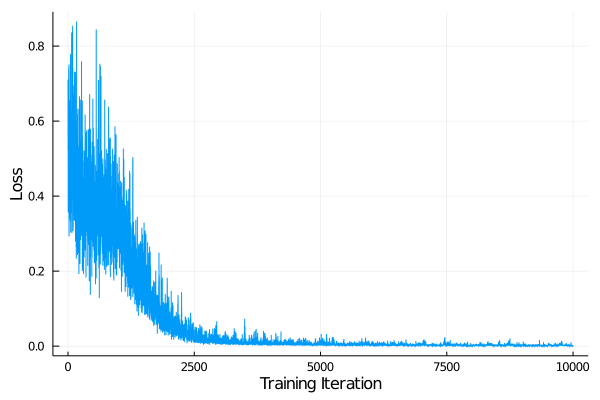

In [66]:
plot(losses, legend=false, background_color="transparent", foreground_color="black")
xaxis!("Training Iteration")
yaxis!("Loss")

We may see from the plot that our model did in fact learn to approximately solve the task! This suggests that we correctly implemented both the forward pass and backpropagation through time!

The loss continuaully decreases and ultimately approaches zero in after approximately 5000 training iterations.

Since the loss is not consistently at zero there is room for a little further fine tuning. We therefore run some additional training steps with a lower learning rate to improve the quality of our solution.

In [64]:
s₀, h₀, Wᵥ, Wᵣ, Wₐ, Wₒ, Wᵩ, losses = train(
    recall_minibatch_generator, LSTM_STATE_DIMENSION, 10000, 0.00001,
    s₀, h₀, Wᵥ, Wᵣ, Wₐ, Wₒ, Wᵩ
);
trained_recall_parameters = (s₀=s₀, h₀=h₀, Wᵥ=Wᵥ, Wᵣ=Wᵣ, Wₐ=Wₐ, Wₒ=Wₒ, Wᵩ=Wᵩ);

Training Progress: 100%|████████████████████████████████| Time: 0:01:38


Let us now run the model with the final weights to validate that it does what we expect. We do this with a randomly sampled example and output $x$ and the model output $\hat{y}$.

In [63]:
x, y = recall_minibatch_generator()
# We will run with only a single sequence of x values
# so we take only the first entry of the minibatch.
x = x[1, :, :]'
ŷ = forward_propagation(x, h₀, s₀, Wᵥ, Wᵣ, Wₐ, Wₒ, Wᵩ)[4]
@show(x)
@show(ŷ);

x = Float32[0.13136344 -0.5879044 -0.6096868 -0.94963413 -1.6039306 0.21389234 0.15515214 0.7297258 1.816721 0.59357226]
ŷ = [-0.5840550068629731]


We see that our LSTM approximately recalls the third input that it sees ignoring all other elements. With a little thought, it can in fact be noted that an LSTM can be set up with weights and activation functions such that this recall is (in practice) exact. We comment further on the use of activation functions for this purpose below. We leave coming up with these weights as an exerise for you which will help to cement an understanding of the mechanisms of the LSTM.

The reason that our trained LSTM has memory with some error is that exact memory requires full saturation of some of the sigmoid functions to keep certain gates fully open/closed. This is done to write the required value to memory at the right time before then ignoring all future inputs and recalling the value from memory at the end. Our training process only approximates this, as the saturation of the sigmoid functions requires large values of the weights which take time to build up with a small learning rate and gradients which diminish as the solution is approached. Furthermore, the $\tanh$ activations of the processed inputs and the cell output transform the information retained in the LSTM in a non-linear way which is difficult to learn to invert in the final layers which produce the ultimate model output. When considering weights that are able to achieve exact recall, feel free to remove these $\tanh$ activations or indeed consider an alternative final activation which may enable exact recall.

However, the results we have shown here demonstrate that our model can indeed learn to memorise. This shows that we have correctly implemented backpropagation through time and that our LSTM can be trained to utilise it's memory to solve a problem. This demonstrates that training signals can propagate through the temporal processing of inputs such that our model can potentially learn long-term dependencies between the inputs and the target values.

Having proven the memory capabiltiy of the LSTM in a simple task, we now turn to a task where the LSTM has to process all values as they arrive and accumulate the processed values to attain a solution.

### Learning to Average with LSTMs
In this section, we try a new task which requires the LSTM to process all values as they are presented to the models as inputs. In this case, we again generate a sequence of 10 values independently drawn from a normal distribution but this time the target value is the average of the presented values.

We begin by implementing a new minibatch generating function for this task.

In [30]:
function make_averaging_minibatch()
    x = randn(rng, Float32, (BATCH_SIZE, SEQUENCE_LENGTH, 1))
    y = mean(x, dims=2)[:]
    return x, y
end;

With this minibatch generator defined, we are free to set up training in the same way as for the previous task.

Training Progress: 100%|████████████████████████████████| Time: 0:00:09


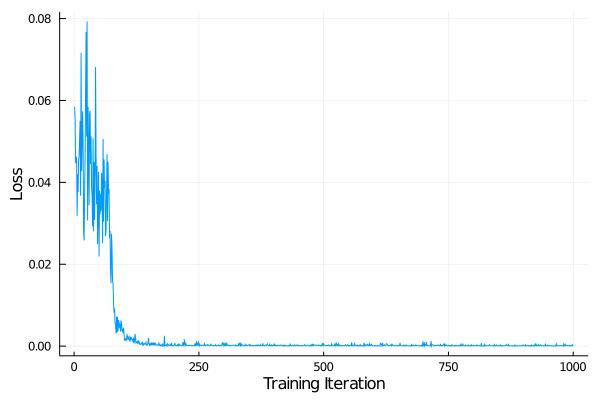

In [69]:
s₀, h₀, Wᵥ, Wᵣ, Wₐ, Wₒ, Wᵩ = initialise_matrices(LSTM_STATE_DIMENSION, 1)
s₀, h₀, Wᵥ, Wᵣ, Wₐ, Wₒ, Wᵩ, losses = train(
    make_averaging_minibatch, LSTM_STATE_DIMENSION, 1000, 0.001, s₀, h₀, Wᵥ, Wᵣ, Wₐ, Wₒ, Wᵩ
)
trained_recall_parameters = (s₀=s₀, h₀=h₀, Wᵥ=Wᵥ, Wᵣ=Wᵣ, Wₐ=Wₐ, Wₒ=Wₒ, Wᵩ=Wᵩ)
plot(losses, legend=false)
xaxis!("Training Iteration", background_color="transparent", foreground_color="black")
yaxis!("Loss")

Again, we may see that our model is able to learn, this time in a case where all input values must be processed. We note that the loss begins very small and approaches zero quickly. This is to be expected as our inputs are independently sampled from a standard normal distribution and therefore have mean zero and a standard deviation of 1. Our network is also initialised with small random weights that have expected value 0 (excluding the bias of the forget gate). Therefore, with no training we may expect our network to output small random values with mean close to zero. The network therefore should not need to adjust weights too far to get to correct outputs.

However, the network doesn't achieve a stable loss at zero which would denote solving the problem. To understand this, we must understand that the network must essentially learn to scale the inputs by one over the sequence length and then keep a running sum of the results which can be output at the end. We believe that this is what the network approximately learns to do which we test below. This is difficult to learn as the forget gate again needs to be fully open so that nothing is forgotten (i.e. removed from the running sum) and the remember gate or the values of the input processing matrix must learn to scale the input value in a way inversely proportional to the input sequence length. Note that this is possible to learn because the sequence length is kept constant throughout training. We also note that the $\tanh$ activations acting on the state again do not help as they transform the inputs in a way that the model cannot then learn an exact inverse for when processing the outputs. This further contributes to the final error in the model.

Let us see how well the model learned to average by running a single set of values through it.

In [24]:
x, y = make_averaging_minibatch()
# We will run with only a single sequence of x values
# so we take only the first entry of the minibatch.
x = x[1, :, :]'
ŷ = forward_propagation(x, h₀, s₀, Wᵥ, Wᵣ, Wₐ, Wₒ, Wᵩ)[4]
@show(x)
@show(mean(x))
@show(ŷ);

x = Float32[0.58350307 -1.291237 1.0158409 -0.36111808 -2.1350634 -1.250227 0.3404669 -1.6338392 0.53022844 -0.90758634]
mean(x) = -0.5109032f0
ŷ = [-0.5073920240094921]


We may see from the forward pass shown above, that our model does indeed approximately learn to average. This shows that our LSTM can use its memory to process entries as they arrive and add them to memory in the context of existing values. The final solution is again approximate due to the drawbacks of gradient descent as well as the concerns regarding the activation functions of the LSTM and their suitability to this simple task.

To futher explore what the LSTM has learned, consider the example below where we pass in a longer sequence than the model saw during training.

In [27]:
x = 0.25 * ones(1, 12)
ŷ = forward_propagation(x, h₀, s₀, Wᵥ, Wᵣ, Wₐ, Wₒ, Wᵩ)[4]
@show(x)
@show(mean(x))
@show(ŷ);

x = [0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25]
mean(x) = 0.25
ŷ = [0.3240314319922502]


In this example, the input sequence is longer than those in the training set. The predicted value is also higher than the true average. This shows that our model has not truly learnt to average but has learned to average sequences of length 10. The fact that the predicted value is higher than the true average suggests that our model is indeed learning a scaled cumulative sum approach to averaging. In the absence of knowledge of the sequence length, the model does not generalise to different sequence lengths.

This shortcoming of our LSTM is however less limiting in real applications for regression on datasets because the rules being learned are likely less rigid and where necessary the dataset can be preprocessed into chunks of known length. The final output from processing one chunk could be used as an initial LSTM state for processing the next for example.

Through this section, we have shown that we can use our LSTM model to approximately learn to average a sequence of values. This is again a simple task designed to demonstrate the abilities and drawbacks of the LSTM formulation. Specifically, we have shown that we can learn to average a sequence of values and therefore that the LSTM is capable of considering all values in the context of previously seen values to arrive at a final prediction. Further exploration has helped us to understand why this solution is only approximate and see some of the limits of the generalisation of the learned solution.

## Conclusion
Through this article, we have explained, implemented and trained an LSTM. The focus has been on deriving backpropagation for the LSTM which itself is all about applying the chain rule to calculate the gradient of the loss with respect to the weights of the LSTM. The repeated action of recurrent models means that there are many paths through which the gradient must be propagated in order to update the model parameters.

By deriving the gradients for our LSTM we have handled weight tying, the caching of intermediate values from the forward pass and propagating gradients through equations with many terms. In this way, we have covered tools and techniques required to understand the training of almost any modern deep learning model. Once the forward pass is laid out, understanding the backward pass should come easily. Hopefully you wont need to derive the gradients from scratch in future!

We have implemented a typical LSTM albeit with only a single output at the final timestep. It may be more common to see an output calculated at each timestep and therefore a prediction and loss at each timestep making for even more gradient paths to follow. We focussed on the single output case here for simplicity. However, with the derivations here it should be simple to extend to the case of making a prediction at each time step.

There are many variants of LSTMs and recurrent models more generally. A notable variant is adding 'peep holes' to an LSTM whereby the values of the gates are allowed to look at the state of the LSTM as well as the previous output and the current input. In our set up, this is akin to concatenating the LSTM cell state $(s_{t-1})$ with $x_t$ and $h_{t-1}$ when forming $h_t^+$.

Another popular recurrent model, similar to the LSTM is the Gated Recurrent Unit (GRU) [(Cho et al., 2014)](https://arxiv.org/abs/1406.1078). Under the GRU there is a single vector which plays the role of both the cell state $(s)$ and the LSTM output $(h)$. Furthermore, the 'forget' and 'remember' gates are constrained such that their elementwise sum is 1.

These variants are discussed in more detail in Chris Olah's great [blog post](http://colah.github.io/posts/2015-08-Understanding-LSTMs/).

These variants of LSTMs or recurrent models more generally often report very similar results ([Greff et al., 2015](https://arxiv.org/abs/1503.04069), [Jozefowicz et al., 2015](http://proceedings.mlr.press/v37/jozefowicz15.html)). They often fall foul of common shortcomings of recurrent models. Critically, they often suffer from diminishing gradients when faced with processing very long sequences. This is despite these variants of RNNs being designed with countermeasures specific to vanishing gradients. This is due to the inability to remove all all sources of diminishing gradients. Some works have sought to further resolve these issues. It is common to see back propagation through time truncated at a point where the gradients are too diminshed to usefully train the parameters. One noteable work aims to replace the true gradient at certain points with synthetic gradients to allow the training signal to propagate further [(Jaderberg et al., 2017)](http://proceedings.mlr.press/v70/jaderberg17a.html).

Recently, the explosion of interest in attention (most notably [dot product self attention](https://arxiv.org/abs/1706.03762v5)) has taken over from recurrent models in many cases. The mechanisms of attention deserve their own article. In short, attention allows context dependent weights to process an input sequence. This has become a key tool in NLP where LSTMs were previously the central tool.

ecurrent models however retain a place in the modern deep learning toolbox. Typical implementations of attention experience $\mathcal{O}(n^2)$ time and space complexity whereas recurrent models generally have linear time and space complexity (where $n$ denotes sequence length). Therefore, recurrent models still have a place where speed is a key concern or where very long sequences are to be processed. There is a vast emerging literature trying to efficiently scale attention to longer and longer sequences.

We recommend exploring and editing the code to consider some of the cases we left out to check your understanding of LSTMs and how they are trained. Do get in touch with any suggestions, comments and corrections.

### Code Requirements
This code was written with Julia 1.5.3 and the following external packages.
```
IJulia v1.23.1
LaTeXStrings v1.2.0
Plots v1.10.1
ProgressMeter v1.4.1
```